# 1. Import Required Libraries

In [2]:
pip install numpy pandas matplotlib seaborn joblib xgboost lightgbm catboost scikit-learn nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import date
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action="ignore")

# 2. Adjusting Row Column Settings

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 3. Loading the data Set

In [5]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 4. Exploratory Data Analysis

In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.select_dtypes(include='number').quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling          

In [8]:
# Change the type of the TotalCharges variable.

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [9]:
# Change the type of the SeniorCitizen variable.

df["SeniorCitizen"] = df["SeniorCitizen"].astype("O")

In [10]:
# Change the representation of the Churn variable in the dataset from "Yes" and "No" to 1 and 0.

df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [11]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# 5. Capturing / Detecting Numeric and Categorical Variables

In [13]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] 

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car] 

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"] 

    num_cols = [col for col in num_cols if col not in num_but_cat] 
    
    print(f"Observations: {dataframe.shape[0]}") 
    print(f"Variables: {dataframe.shape[1]}") 
    print(f'cat_cols: {len(cat_cols)}') 
    print(f'cat_but_car: {len(cat_but_car)}') 
    print(f'num_but_cat: {len(num_but_cat)}')


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [14]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
cat_but_car: 1
num_but_cat: 1


In [15]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [16]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [17]:
cat_but_car

['customerID']

# 6. Analysis of Categorical Variables

In [18]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################


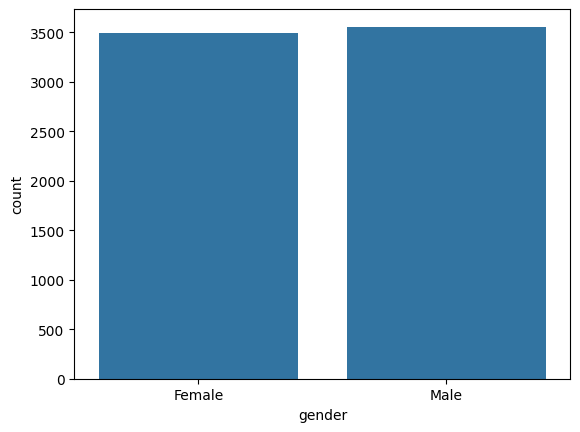

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5901 83.785
1                       1142 16.215
##########################################


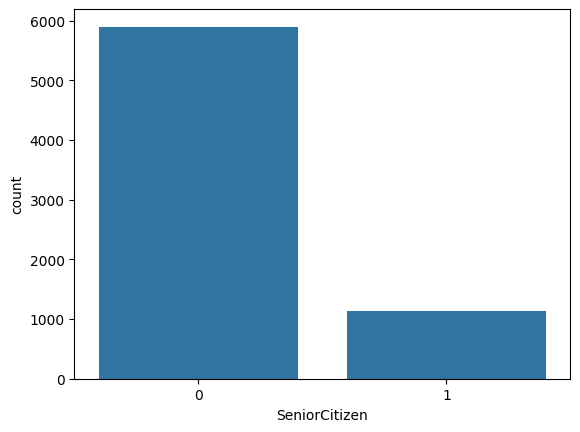

         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################


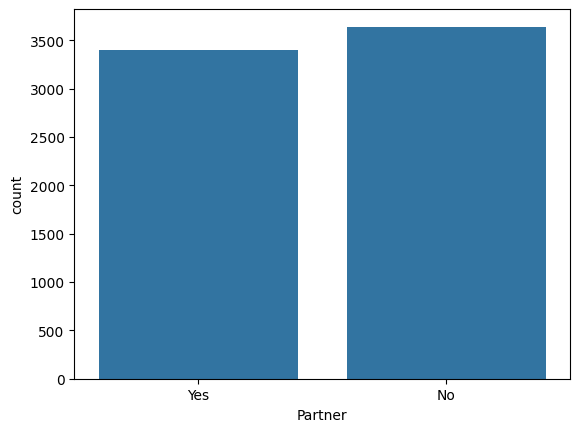

            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################


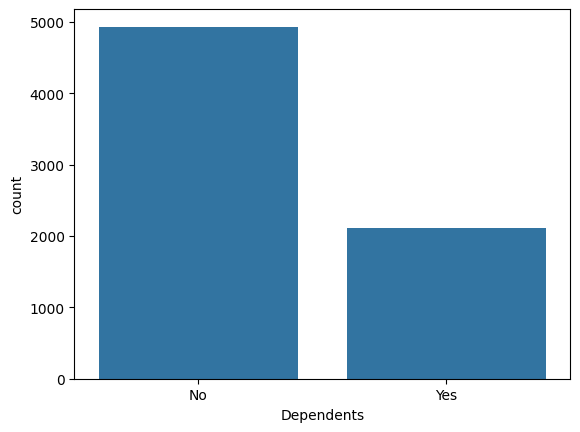

              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################


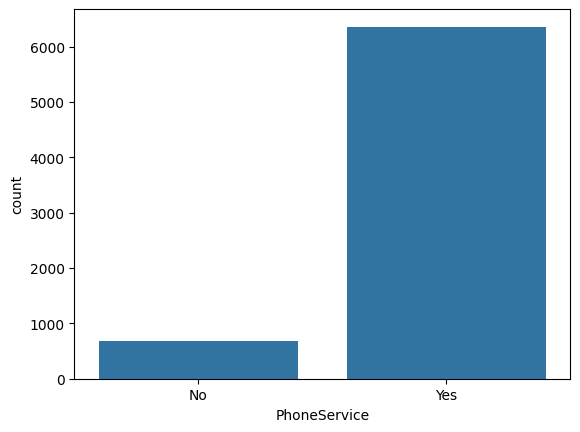

                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################


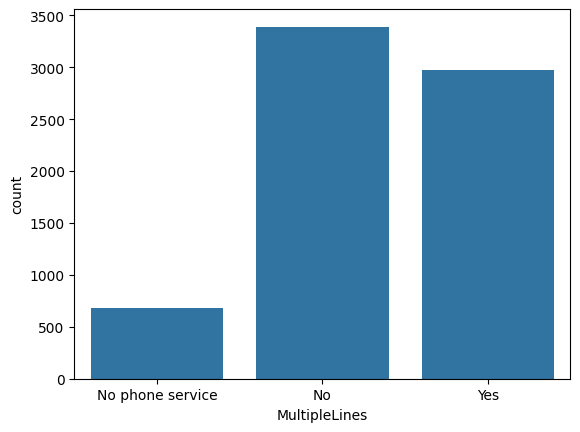

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
##########################################


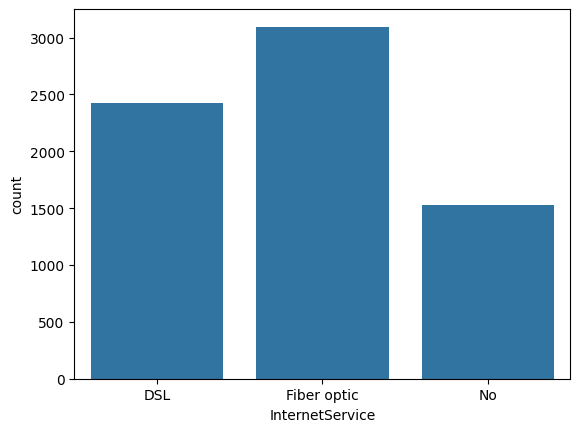

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
##########################################


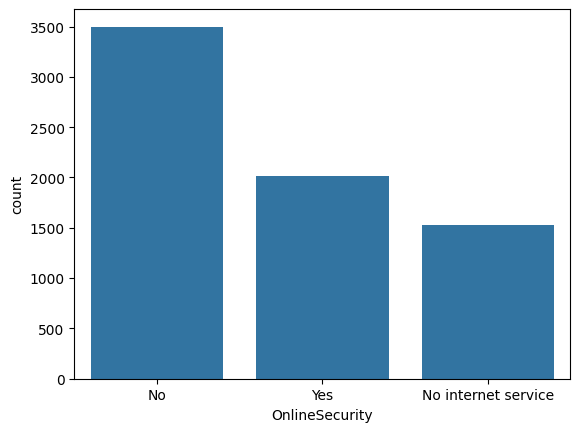

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
##########################################


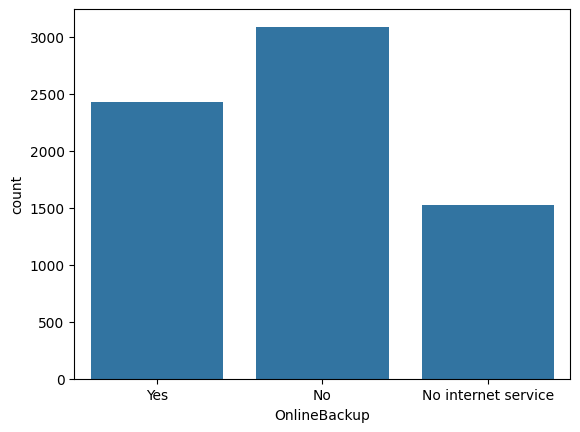

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
##########################################


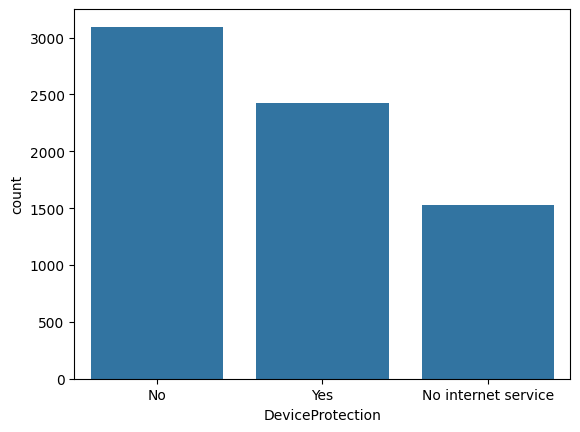

                     TechSupport  Ratio
TechSupport                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
##########################################


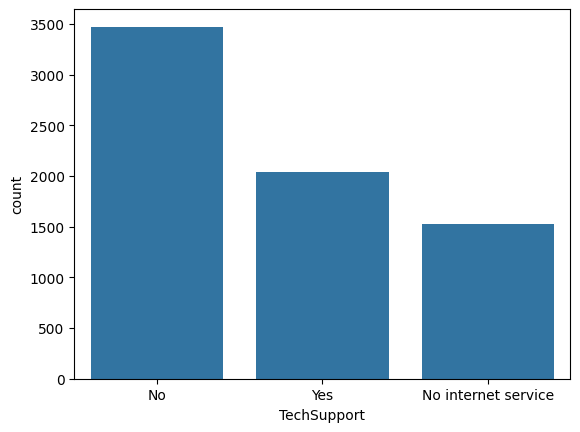

                     StreamingTV  Ratio
StreamingTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
##########################################


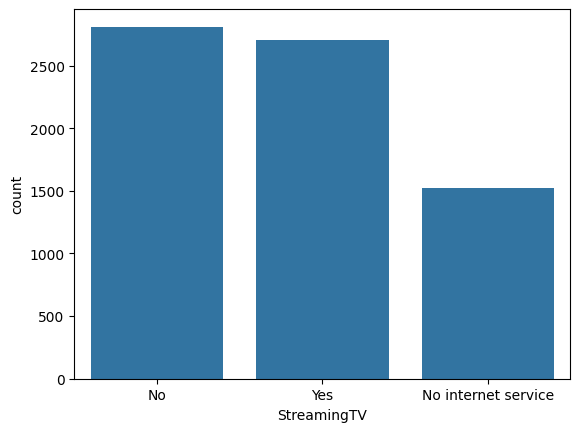

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
##########################################


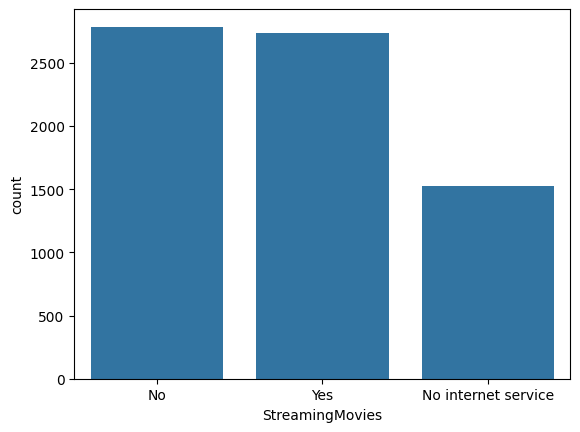

                Contract  Ratio
Contract                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
##########################################


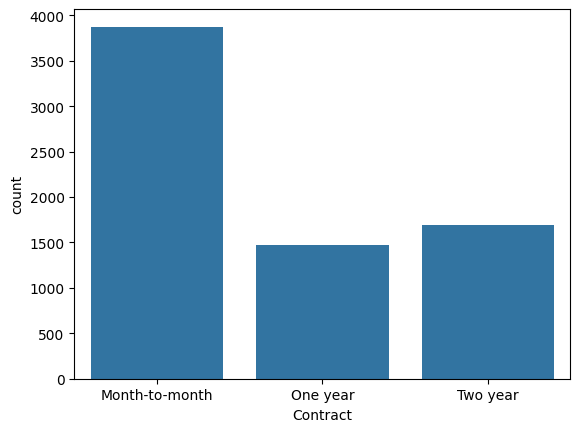

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4171 59.222
No                            2872 40.778
##########################################


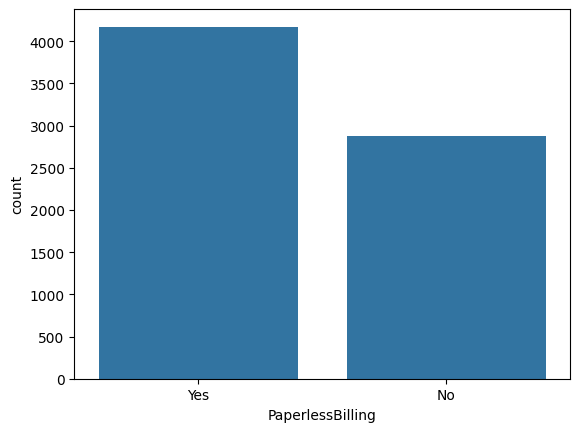

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
##########################################


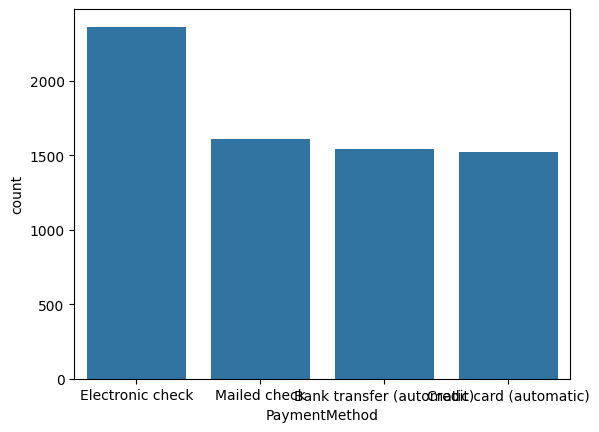

       Churn  Ratio
Churn              
0       5174 73.463
1       1869 26.537
##########################################


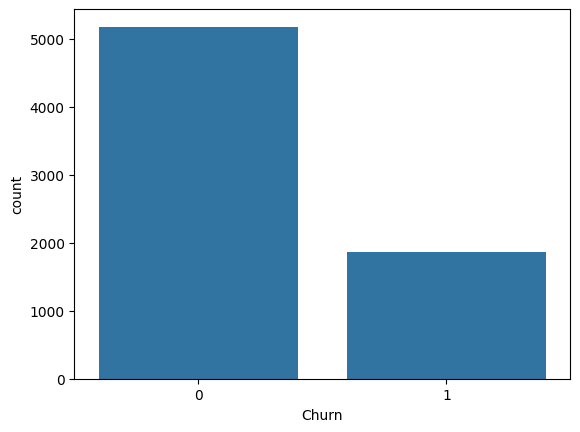

In [19]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

# 7. Analysis of Numerical Variables

In [20]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


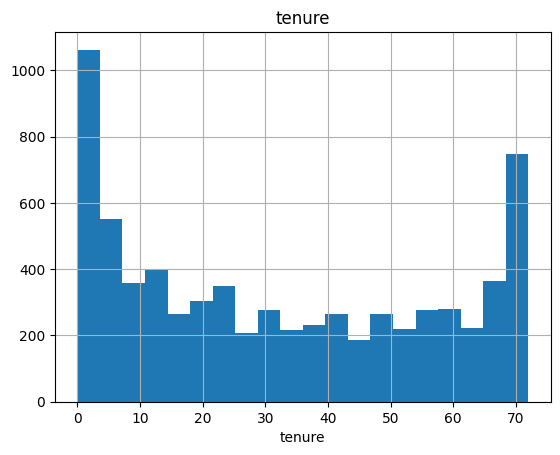

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


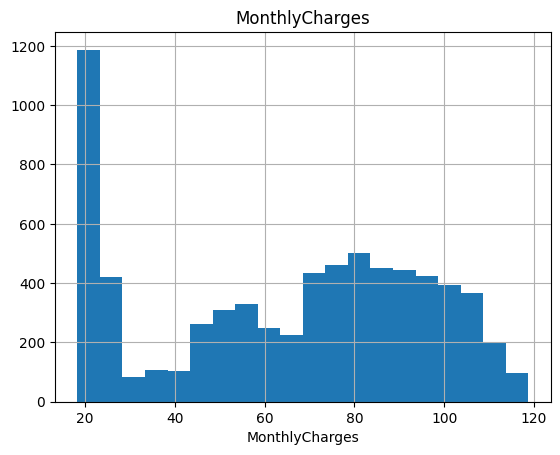

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


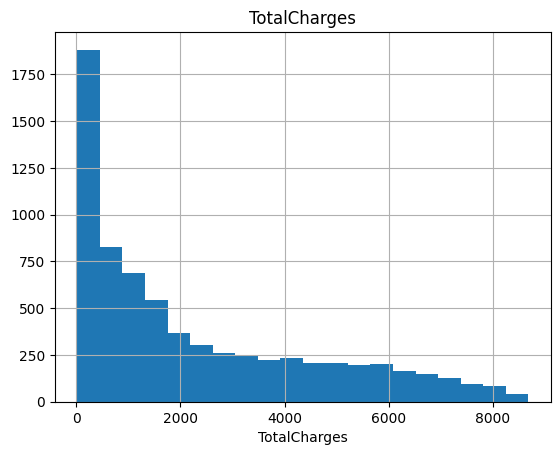

In [21]:
for col in num_cols:
    num_summary(df, col, plot=True)

# 8. Analysis of Numeric Variables by Target

In [22]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [23]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




# 9. Analysis of Categorical Variables by Target

In [24]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")


In [26]:
for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


SeniorCitizen
               TARGET_MEAN  Count  Ratio
SeniorCitizen                           
0                    0.236   5901 83.785
1                    0.417   1142 16.215


Partner
         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


Dependents
            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


PhoneService
              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9

# 10. Examining the Logarithm of the Dependent Variable

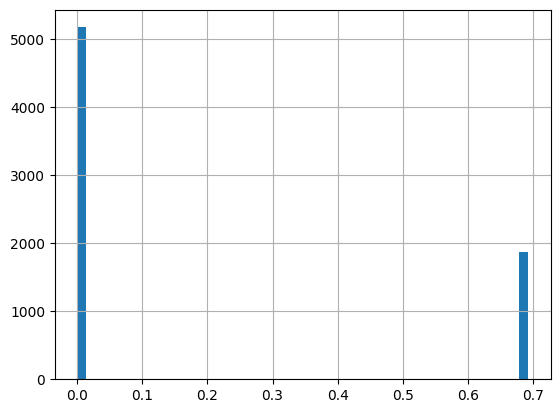

In [27]:
np.log1p(df["Churn"]).hist(bins=50)
plt.show(block=True)

# 11. Correlation Analysis

In [28]:
corr = df[num_cols].corr()

In [29]:
corr

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.826
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.826,0.651,1.000


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    numeric_df = dataframe.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    cor_matrix = corr.abs()

    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [column for column in upper_triangle_matrix.columns if any(upper_triangle_matrix[column] > corr_th)]

    if plot:
        plt.figure(figsize=(12, 10))
        sns.set(style="white")
        cmap = sns.color_palette("Blues", as_cmap=True)
        sns.heatmap(cor_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": .5})
        plt.title("Correlation Matrix", fontsize=16, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    return drop_list


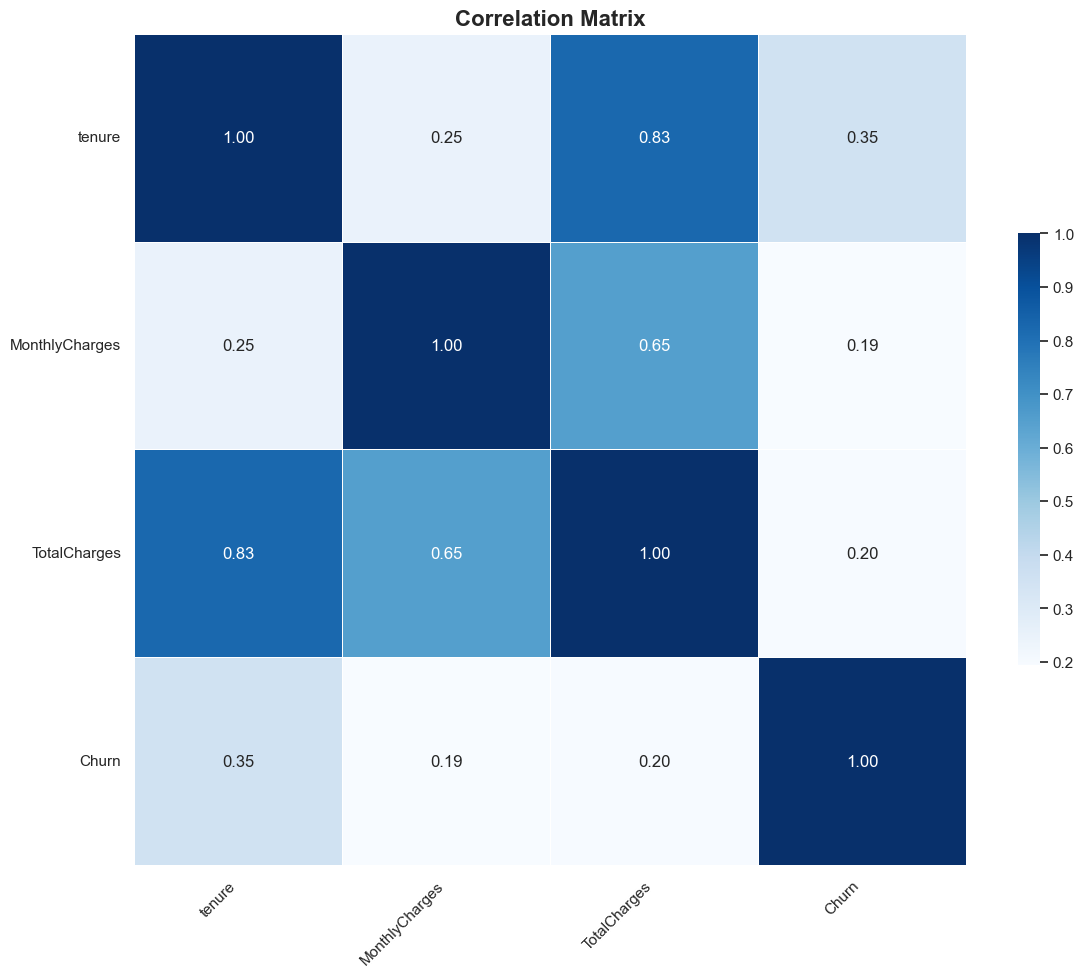

['TotalCharges']

In [31]:
high_correlated_cols(df, plot=True)

# 12. Feature Engineering

- Missing Values Detection
- Outlier Detection (Outliers)
- Feature Extraction

# 13. Missing Value Analysis

In [32]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [33]:
def missing_values_table(dataframe, na_name=False, plot=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    
    if plot:
        # Plot the missing values
        plt.figure(figsize=(10, 8))
        bars = plt.bar(missing_df.index, missing_df['ratio'], color='purple')
        plt.xlabel('Features')
        plt.ylabel('Percentage of Missing Values')
        plt.title('Missing Values by Feature')
        
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')
        
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show(block=True)
    
    if na_name:
        return na_columns

              n_miss  ratio
TotalCharges      11  0.160


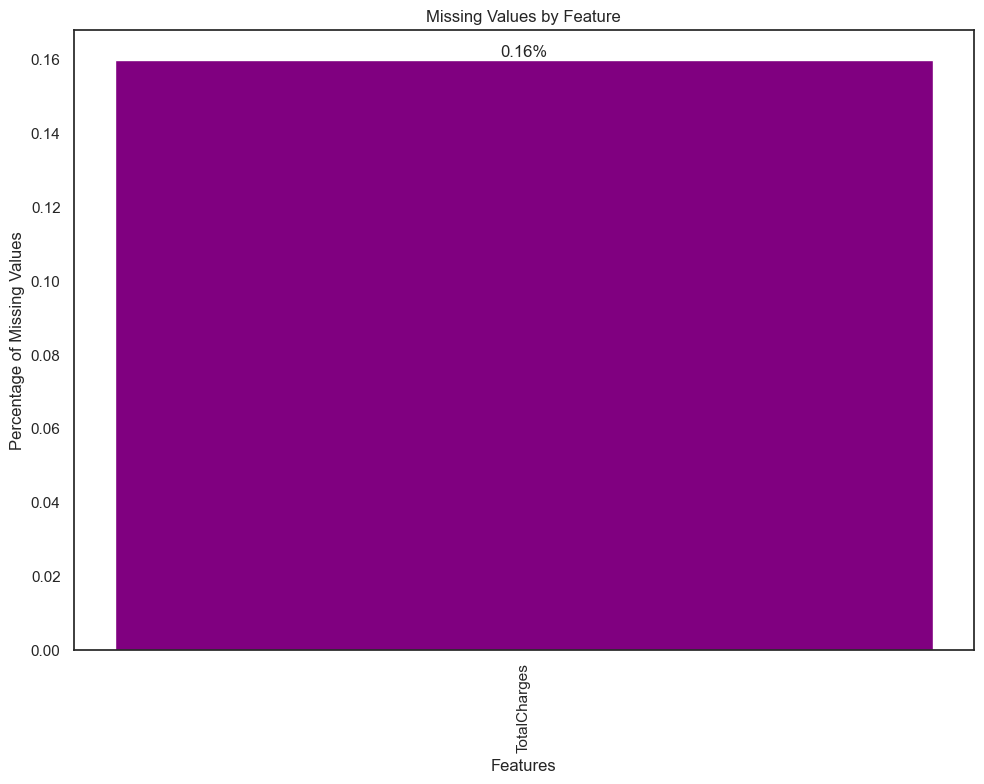

In [34]:
na_columns = missing_values_table(df, na_name=True, plot=True)

In [35]:
def missing_vs_target(dataframe, target, na_columns, plot=False):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
        if plot:
            # Plotting the target mean by NA flag
            plt.figure(figsize=(6, 4))
            temp_df.groupby(col)[target].mean().plot(kind='bar', color='purple')
            plt.xlabel(col)
            plt.ylabel('Target Mean')
            plt.title(f'Target Mean by {col}')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show(block=True)

                      TARGET_MEAN  Count
TotalCharges_NA_FLAG                    
0                           0.266   7032
1                           0.000     11




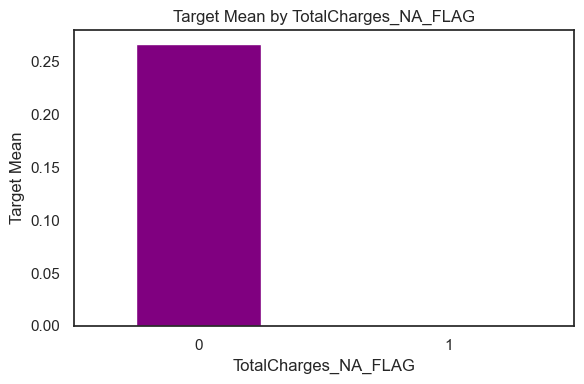

In [36]:
missing_vs_target(df, "Churn", na_columns, plot=True)

In [37]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

In [38]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# 14. Outlier Analysis

In [39]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [40]:
def check_outlier(dataframe, col_name, plot=False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]
    if outliers.any(axis=None):
        if plot:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=dataframe[col_name])
            plt.title(f'Outliers in {col_name}')
            plt.show()
        return True
    else:
        return False

In [41]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [42]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


# 15. Base Model

In [43]:
dff = df.copy()

In [44]:
cat_cols = [col for col in cat_cols if col not in ["Churn"]]

In [45]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [46]:
# One-Hot-Encoding

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [47]:
dff = one_hot_encoder(dff, cat_cols)

In [48]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.850,29.850,0,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,5575-GNVDE,34,56.950,1889.500,0,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,3668-QPYBK,2,53.850,108.150,1,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,7795-CFOCW,45,42.300,1840.750,0,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,9237-HQITU,2,70.700,151.650,1,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


In [49]:
# Standardization

scaler = RobustScaler()

In [50]:
dff[num_cols] = scaler.fit_transform(dff[num_cols])

In [51]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,-0.609,-0.745,-0.404,0,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,5575-GNVDE,0.109,-0.247,0.145,0,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,3668-QPYBK,-0.587,-0.304,-0.381,1,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,7795-CFOCW,0.348,-0.516,0.131,0,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,9237-HQITU,-0.587,0.006,-0.368,1,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


In [52]:
# Create the Dependent Variable.

y = dff["Churn"]

In [53]:
# Create Independent Variables.

X = dff.drop(["Churn","customerID"], axis=1)

In [54]:
models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

In [55]:
base_models_metrics = []

In [56]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    verbosity=-1,       # suppress LightGBM warnings
    random_state=42     # optional, for reproducibility
)

model.fit(X, y)


LGBMClassifier(random_state=42, verbosity=-1)

In [57]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    
    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)
    
    base_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })
    
    print(f"########## {name} ##########")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")


########## LR ##########
Accuracy: 0.8041
AUC: 0.8452
Recall: 0.5516
Precision: 0.6554
F1: 0.5989
########## KNN ##########
Accuracy: 0.7674
AUC: 0.7802
Recall: 0.5313
Precision: 0.5659
F1: 0.548
########## CART ##########
Accuracy: 0.7294
AUC: 0.6547
Recall: 0.4917
Precision: 0.4899
F1: 0.4906
########## RF ##########
Accuracy: 0.7889
AUC: 0.8172
Recall: 0.4842
Precision: 0.6346
F1: 0.5492
########## XGB ##########
Accuracy: 0.7832
AUC: 0.8193
Recall: 0.5168
Precision: 0.609
F1: 0.5587
########## LightGBM ##########
Accuracy: 0.7944
AUC: 0.8364
Recall: 0.5222
Precision: 0.6389
F1: 0.5743
########## CatBoost ##########
Accuracy: 0.7965
AUC: 0.8395
Recall: 0.5061
Precision: 0.6512
F1: 0.5692


# 16. Comparison of Metrics for Different Models Before Feature Engineering

In [58]:
# Dictionary containing the updated metric results
metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [base_models_metrics[0]['Accuracy'], base_models_metrics[1]['Accuracy'],
                 base_models_metrics[2]['Accuracy'], base_models_metrics[3]['Accuracy'],
                 base_models_metrics[4]['Accuracy'], base_models_metrics[5]['Accuracy'],
                 base_models_metrics[6]['Accuracy']],
    "AUC": [base_models_metrics[0]['AUC'], base_models_metrics[1]['AUC'],
            base_models_metrics[2]['AUC'], base_models_metrics[3]['AUC'],
            base_models_metrics[4]['AUC'], base_models_metrics[5]['AUC'],
            base_models_metrics[6]['AUC']],
    "Recall": [base_models_metrics[0]['Recall'], base_models_metrics[1]['Recall'],
               base_models_metrics[2]['Recall'], base_models_metrics[3]['Recall'],
               base_models_metrics[4]['Recall'], base_models_metrics[5]['Recall'],
               base_models_metrics[6]['Recall']],
    "Precision": [base_models_metrics[0]['Precision'], base_models_metrics[1]['Precision'],
                  base_models_metrics[2]['Precision'], base_models_metrics[3]['Precision'],
                  base_models_metrics[4]['Precision'], base_models_metrics[5]['Precision'],
                  base_models_metrics[6]['Precision']],
    "F1": [base_models_metrics[0]['F1'], base_models_metrics[1]['F1'],
           base_models_metrics[2]['F1'], base_models_metrics[3]['F1'],
           base_models_metrics[4]['F1'], base_models_metrics[5]['F1'],
           base_models_metrics[6]['F1']]
}

# Create a DataFrame from the updated metrics dictionary
results_df = pd.DataFrame(metrics)

# Sort the DataFrame by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Create the figure for the graph
fig = go.Figure()

# Colors for the metrics
colors = ["purple", "green", "blue", "orange", "red"]

# Add traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        marker_color=color,
        name=metric,
        text=results_df[metric],
        textposition='auto'
    ))

# Set axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Metric Score",
    title="Comparison of Metrics for Different Models Before Feature Engineering"
)

# Display the graph
fig.show(block=True)


# 17. Feature Importance For Base Model

In [74]:
models = [RandomForestClassifier(),
              XGBClassifier(),
              LGBMClassifier(),
              CatBoostClassifier(verbose=False, random_state=12345)
              ]

In [75]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')


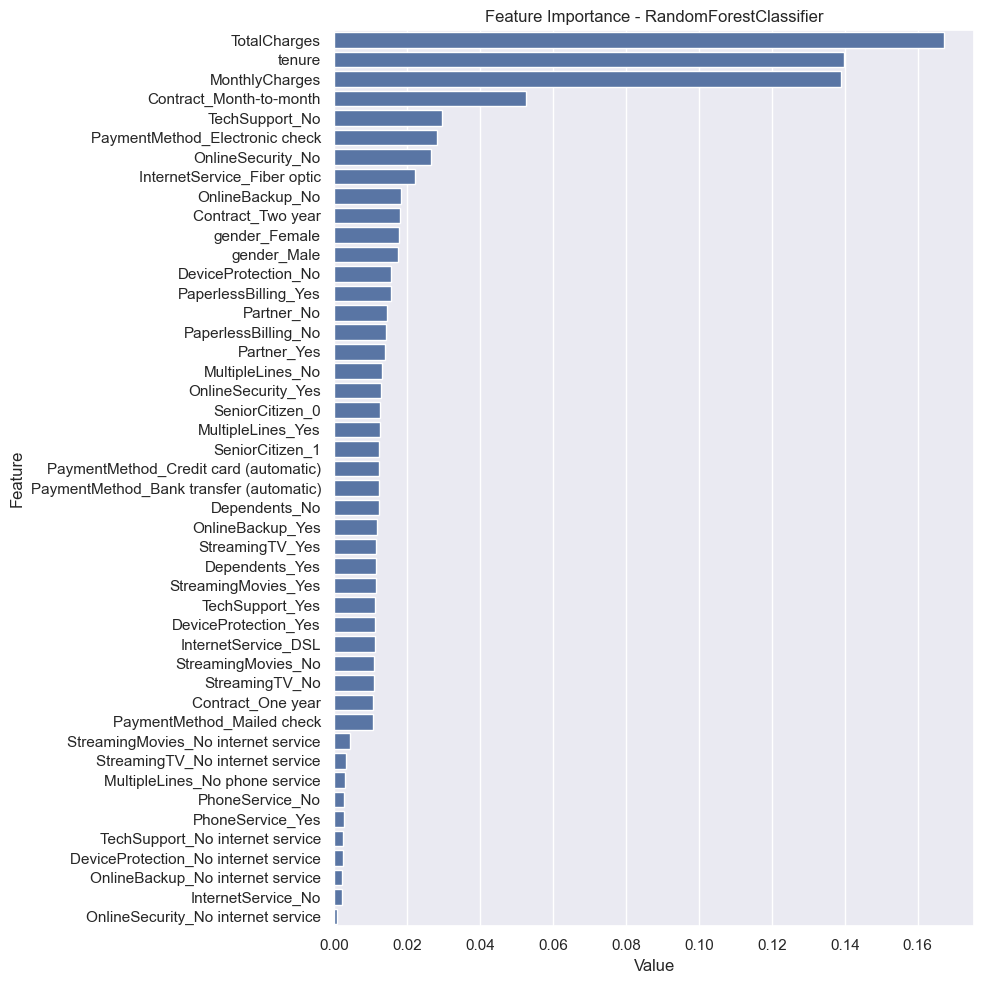

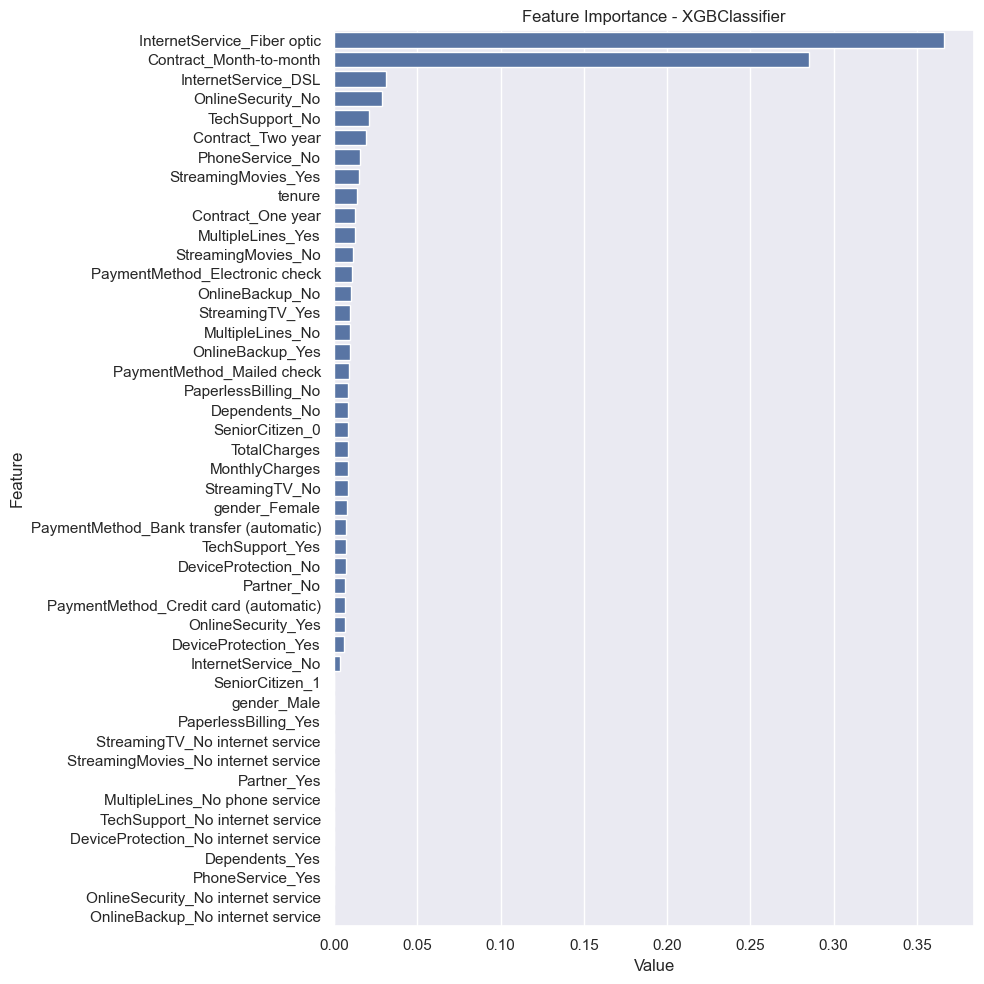

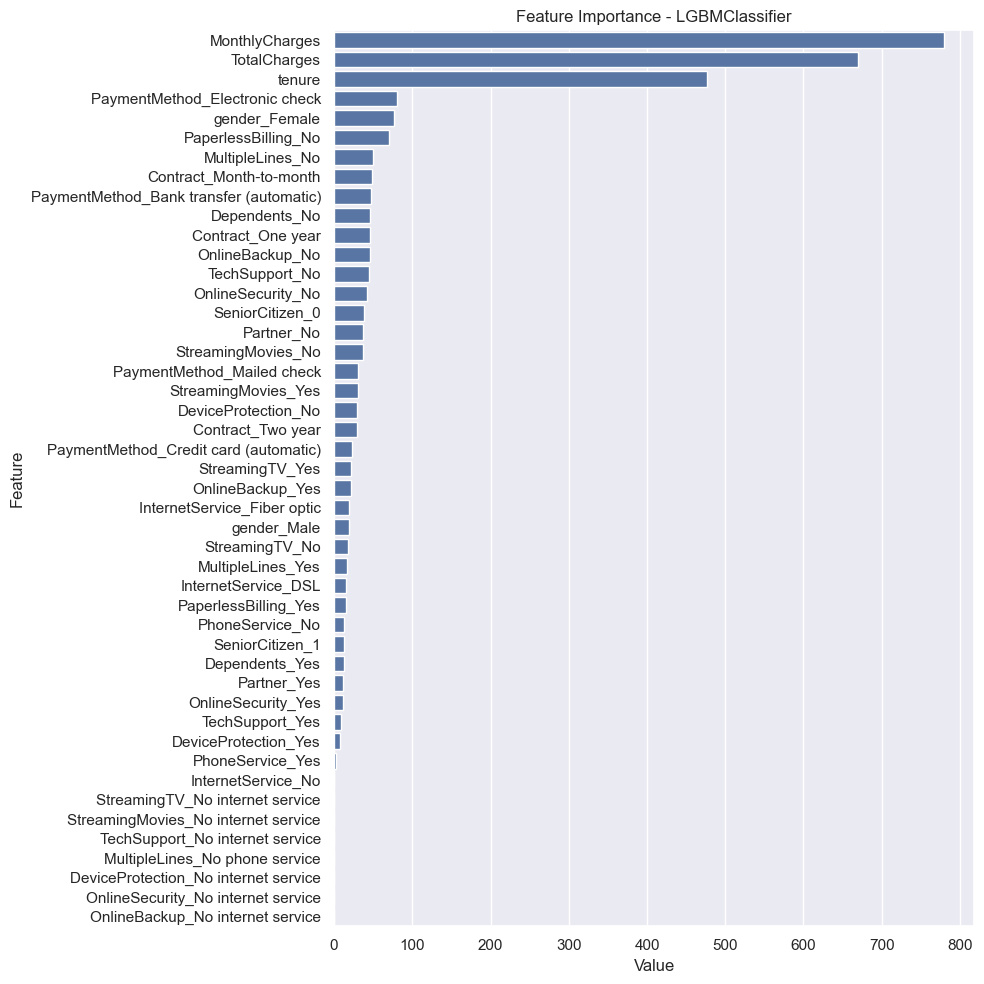

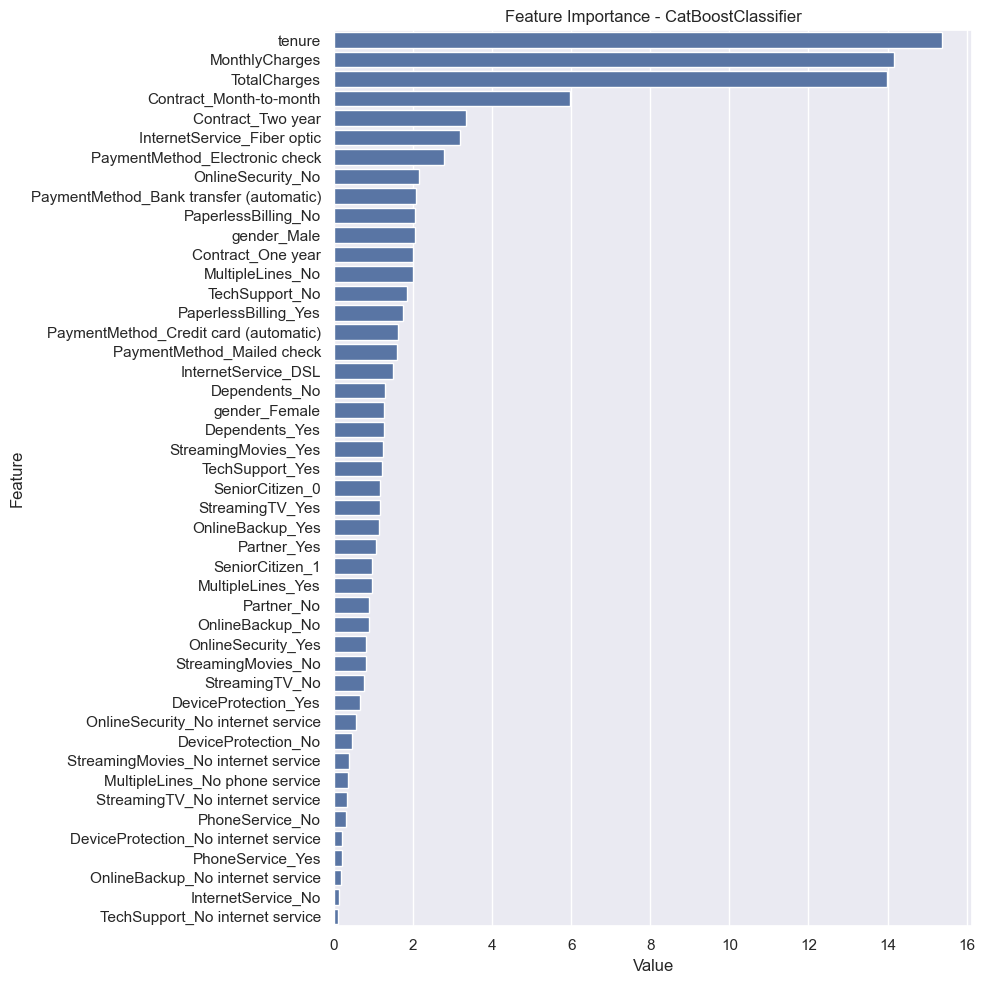

In [76]:
for model in models:
    model.fit(X, y)
    plot_importance(model, X)

# 18. Feature Extraction

In [77]:
# Create an annual categorical variable from the variable Tenure

df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [78]:
# Specify customers with a 1 or 2 year contract as Engaged

df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [79]:
# People who do not receive any support, backup or protection

df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [80]:
# Young customers with a monthly contract

df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [81]:
# Total number of services received by the person

df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [82]:
# People who receive any streaming service

df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [83]:
# Does the person make automatic payments?

df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [84]:
# average monthly payment

df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

In [85]:
# Increase in current price compared to average price

df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

In [86]:
# Fee per service

df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [87]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


In [88]:
df.shape

(7043, 31)

# 19. ENCODING

In [89]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] 

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car] 

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"] 

    num_cols = [col for col in num_cols if col not in num_but_cat] 
    
    print(f"Observations: {dataframe.shape[0]}") 
    print(f"Variables: {dataframe.shape[1]}") 
    print(f'cat_cols: {len(cat_cols)}') 
    print(f'num_cols: {len(num_cols)}') 
    print(f'cat_but_car: {len(cat_but_car)}') 
    print(f'num_but_cat: {len(num_but_cat)}') 


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [90]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 7


In [91]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'Churn',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [92]:
num_cols

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'NEW_AVG_Charges',
 'NEW_Increase',
 'NEW_AVG_Service_Fee']

In [93]:
cat_but_car

['customerID']

In [94]:
# Label Encoding

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [95]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

In [96]:
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling']

In [97]:
for col in binary_cols:
    df = label_encoder(df, col)

In [98]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


In [99]:
# One-Hot Encoding

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]

In [100]:
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [101]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [102]:
df = one_hot_encoder(df, cat_cols)

In [103]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_0-1 Year,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_Engaged_0,NEW_Engaged_1,NEW_noProt_0,NEW_noProt_1,NEW_Young_Not_Engaged_0,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_0,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_0,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,0,1,0,1,0,1,29.850,29.850,0,1,14.925,0.500,14.925,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
1,5575-GNVDE,1,0,0,0,34,1,0,56.950,1889.500,0,3,53.986,0.948,14.238,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False,True,False,True,False
2,3668-QPYBK,1,0,0,0,2,1,1,53.850,108.150,1,3,36.050,0.669,13.463,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
3,7795-CFOCW,1,0,0,0,45,0,0,42.300,1840.750,0,3,40.016,0.946,10.575,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,True,False,False,True
4,9237-HQITU,0,0,0,0,2,1,1,70.700,151.650,1,1,50.550,0.715,35.350,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False


# 20. Standardization Process

In [104]:
scaler = RobustScaler()

In [105]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [106]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_0-1 Year,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_Engaged_0,NEW_Engaged_1,NEW_noProt_0,NEW_noProt_1,NEW_Young_Not_Engaged_0,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_0,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_0,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,0,1,0,-0.609,0,1,-0.745,-0.404,0,1,-0.788,-4.604,-0.061,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
1,5575-GNVDE,1,0,0,0,0.109,1,0,-0.247,0.145,0,3,-0.122,-0.110,-0.136,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False,True,False,True,False
2,3668-QPYBK,1,0,0,0,-0.587,1,1,-0.304,-0.381,1,3,-0.428,-2.904,-0.221,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
3,7795-CFOCW,1,0,0,0,0.348,0,0,-0.516,0.131,0,3,-0.360,-0.129,-0.537,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,True,False,False,True
4,9237-HQITU,0,0,0,0,-0.587,1,1,0.006,-0.368,1,1,-0.181,-2.447,2.172,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
5,9305-CDSKC,0,0,0,0,-0.457,1,1,0.539,-0.170,1,4,0.512,-0.442,0.486,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,False,True,True,False
6,1452-KIOVK,1,0,0,1,-0.152,1,1,0.345,0.163,0,3,0.402,-0.077,0.742,False,False,True,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True
7,6713-OKOMC,0,0,0,0,-0.413,0,0,-0.747,-0.324,0,1,-0.575,-0.365,-0.067,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,True,True,False,True,False
8,7892-POOKP,0,0,1,0,-0.022,1,1,0

# 21. Creating Model 

In [107]:
y = df["Churn"]

In [108]:
X = df.drop(["Churn","customerID"], axis=1)

In [109]:
models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

In [110]:
last_models_metrics = []

In [112]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    
    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)
    
    last_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })
    
    print(f"########## {name} ##########")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")


########## LR ##########
Accuracy: 0.8052
AUC: 0.8499
Recall: 0.5367
Precision: 0.6651
F1: 0.5939
########## KNN ##########
Accuracy: 0.7711
AUC: 0.7836
Recall: 0.5254
Precision: 0.5756
F1: 0.5492
########## CART ##########
Accuracy: 0.7311
AUC: 0.6583
Recall: 0.4997
Precision: 0.4936
F1: 0.4965
########## RF ##########
Accuracy: 0.7893
AUC: 0.823
Recall: 0.4858
Precision: 0.6357
F1: 0.5506
########## XGB ##########
Accuracy: 0.7805
AUC: 0.819
Recall: 0.4912
Precision: 0.6078
F1: 0.5431
########## LightGBM ##########
Accuracy: 0.7916
AUC: 0.836
Recall: 0.5126
Precision: 0.633
F1: 0.5662
########## CatBoost ##########
Accuracy: 0.7984
AUC: 0.8394
Recall: 0.5104
Precision: 0.654
F1: 0.5734


# 22. Comparison of Metrics for Different Models After Feature Engineering

In [114]:
# Dictionary containing the updated metric results
metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [last_models_metrics[0]['Accuracy'], last_models_metrics[1]['Accuracy'],
                 last_models_metrics[2]['Accuracy'], last_models_metrics[3]['Accuracy'],
                 last_models_metrics[4]['Accuracy'], last_models_metrics[5]['Accuracy'],
                 last_models_metrics[6]['Accuracy']],
    "AUC": [last_models_metrics[0]['AUC'], last_models_metrics[1]['AUC'],
            last_models_metrics[2]['AUC'], last_models_metrics[3]['AUC'],
            last_models_metrics[4]['AUC'], last_models_metrics[5]['AUC'],
            last_models_metrics[6]['AUC']],
    "Recall": [last_models_metrics[0]['Recall'], last_models_metrics[1]['Recall'],
               last_models_metrics[2]['Recall'], last_models_metrics[3]['Recall'],
               last_models_metrics[4]['Recall'], last_models_metrics[5]['Recall'],
               last_models_metrics[6]['Recall']],
    "Precision": [last_models_metrics[0]['Precision'], last_models_metrics[1]['Precision'],
                  last_models_metrics[2]['Precision'], last_models_metrics[3]['Precision'],
                  last_models_metrics[4]['Precision'], last_models_metrics[5]['Precision'],
                  last_models_metrics[6]['Precision']],
    "F1": [last_models_metrics[0]['F1'], last_models_metrics[1]['F1'],
           last_models_metrics[2]['F1'], last_models_metrics[3]['F1'],
           last_models_metrics[4]['F1'], last_models_metrics[5]['F1'],
           last_models_metrics[6]['F1']]
}

# Creating a DataFrame from the updated metrics dictionary
results_df = pd.DataFrame(metrics)

# Sorting the DataFrame by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Colors for the metrics
colors = ["purple", "green", "blue", "orange", "red"]

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        marker_color=color,
        name=metric,
        text=results_df[metric],
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Metric Score",
    title="Comparison of Metrics for Different Models After Feature Engineering"
)

# Displaying the graph
fig.show(block=True)



# 23. Feature Importance

In [115]:
models = [RandomForestClassifier(),
              XGBClassifier(),
              LGBMClassifier(),
              CatBoostClassifier(verbose=False, random_state=12345)
              ]

In [116]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')

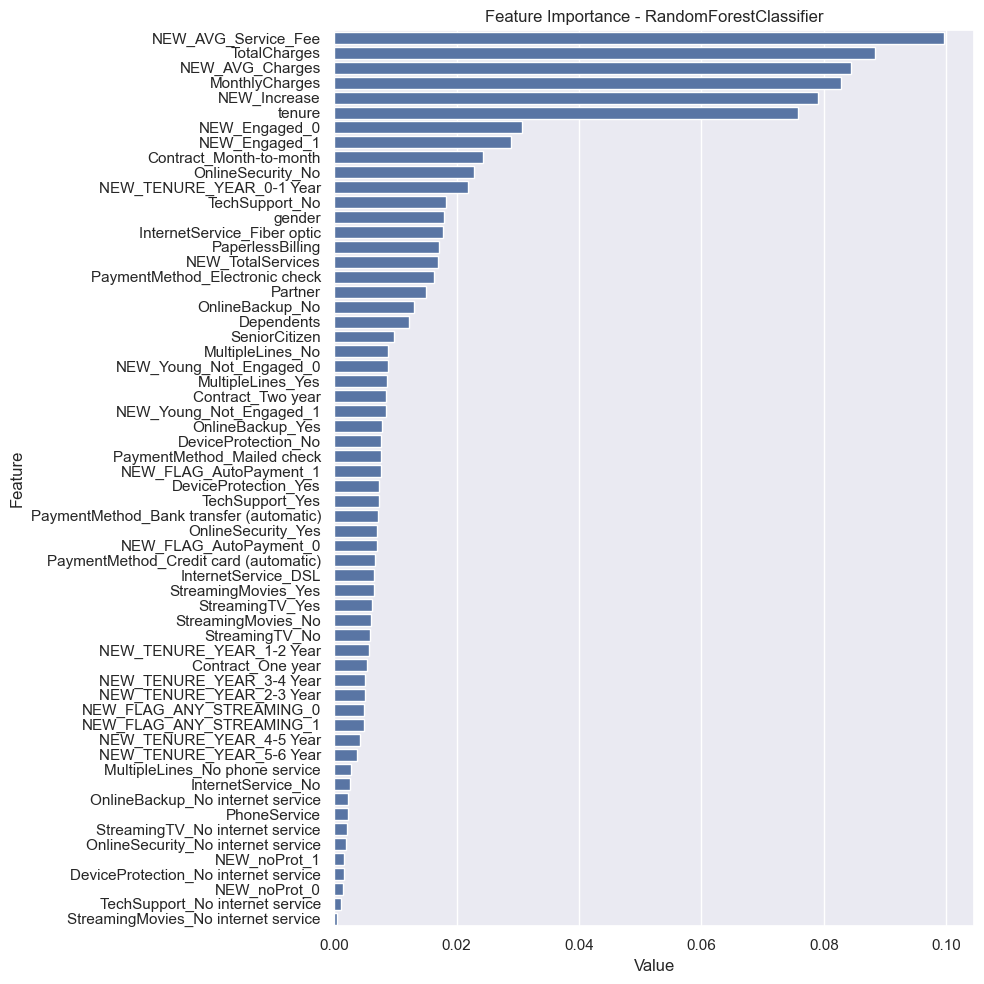

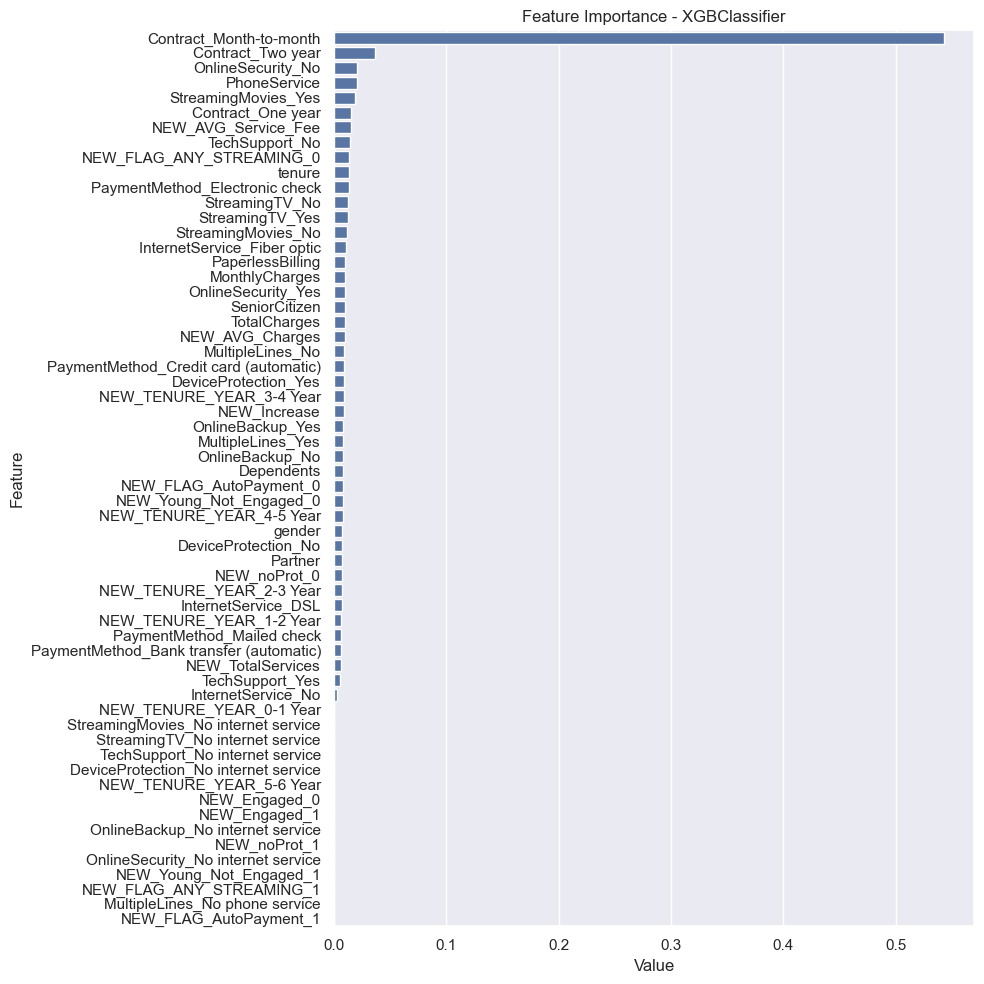

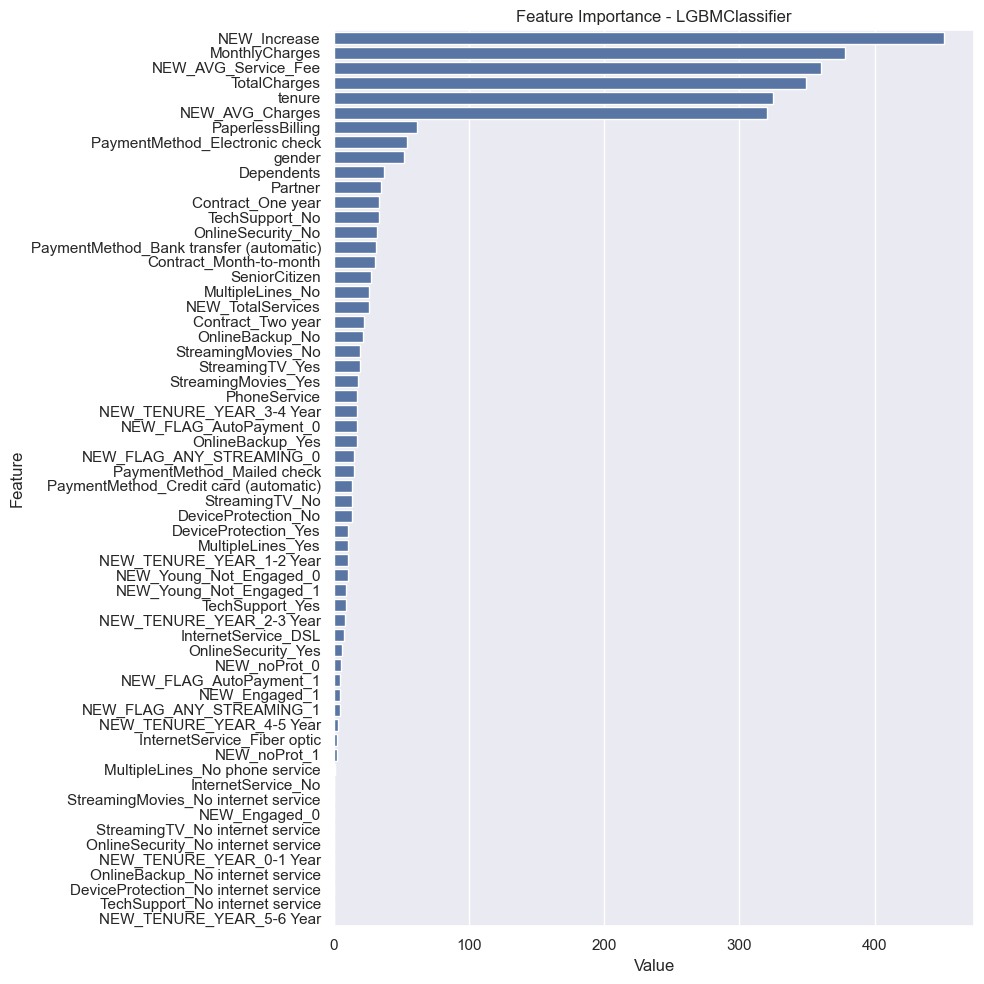

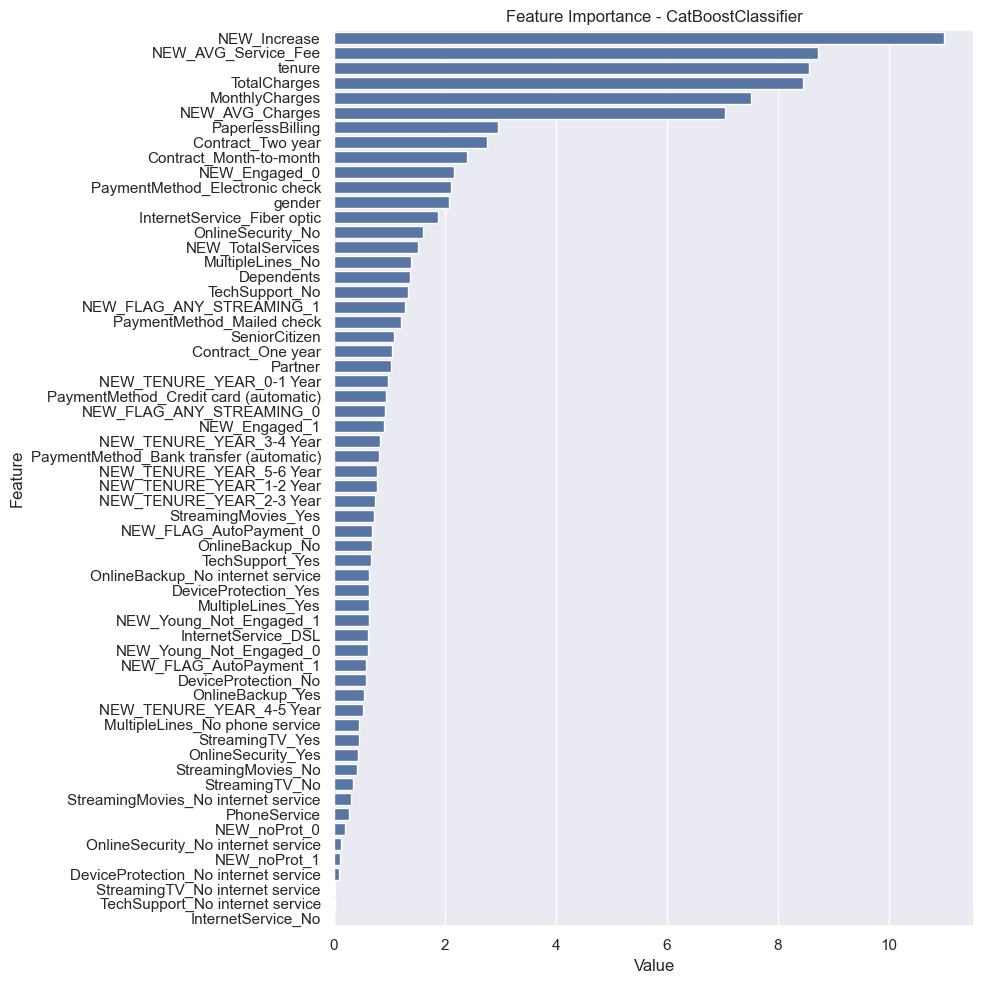

In [117]:
for model in models:
    model.fit(X, y)
    plot_importance(model, X)

# 24. Metric Improvement Comparison After Feature Engineering

In [118]:
# Dictionary containing the updated metric results
base_metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [base_models_metrics[0]['Accuracy'], base_models_metrics[1]['Accuracy'],
                 base_models_metrics[2]['Accuracy'], base_models_metrics[3]['Accuracy'],
                 base_models_metrics[4]['Accuracy'], base_models_metrics[5]['Accuracy'],
                 base_models_metrics[6]['Accuracy']],
    "AUC": [base_models_metrics[0]['AUC'], base_models_metrics[1]['AUC'],
            base_models_metrics[2]['AUC'], base_models_metrics[3]['AUC'],
            base_models_metrics[4]['AUC'], base_models_metrics[5]['AUC'],
            base_models_metrics[6]['AUC']],
    "Recall": [base_models_metrics[0]['Recall'], base_models_metrics[1]['Recall'],
               base_models_metrics[2]['Recall'], base_models_metrics[3]['Recall'],
               base_models_metrics[4]['Recall'], base_models_metrics[5]['Recall'],
               base_models_metrics[6]['Recall']],
    "Precision": [base_models_metrics[0]['Precision'], base_models_metrics[1]['Precision'],
                  base_models_metrics[2]['Precision'], base_models_metrics[3]['Precision'],
                  base_models_metrics[4]['Precision'], base_models_metrics[5]['Precision'],
                  base_models_metrics[6]['Precision']],
    "F1": [base_models_metrics[0]['F1'], base_models_metrics[1]['F1'],
           base_models_metrics[2]['F1'], base_models_metrics[3]['F1'],
           base_models_metrics[4]['F1'], base_models_metrics[5]['F1'],
           base_models_metrics[6]['F1']]
}

last_metrics = {
    "Model": ["LR", "KNN", "CART", "RF", "XGB", "LightGBM", "CatBoost"],
    "Accuracy": [last_models_metrics[0]['Accuracy'], last_models_metrics[1]['Accuracy'],
                 last_models_metrics[2]['Accuracy'], last_models_metrics[3]['Accuracy'],
                 last_models_metrics[4]['Accuracy'], last_models_metrics[5]['Accuracy'],
                 last_models_metrics[6]['Accuracy']],
    "AUC": [last_models_metrics[0]['AUC'], last_models_metrics[1]['AUC'],
            last_models_metrics[2]['AUC'], last_models_metrics[3]['AUC'],
            last_models_metrics[4]['AUC'], last_models_metrics[5]['AUC'],
            last_models_metrics[6]['AUC']],
    "Recall": [last_models_metrics[0]['Recall'], last_models_metrics[1]['Recall'],
               last_models_metrics[2]['Recall'], last_models_metrics[3]['Recall'],
               last_models_metrics[4]['Recall'], last_models_metrics[5]['Recall'],
               last_models_metrics[6]['Recall']],
    "Precision": [last_models_metrics[0]['Precision'], last_models_metrics[1]['Precision'],
                  last_models_metrics[2]['Precision'], last_models_metrics[3]['Precision'],
                  last_models_metrics[4]['Precision'], last_models_metrics[5]['Precision'],
                  last_models_metrics[6]['Precision']],
    "F1": [last_models_metrics[0]['F1'], last_models_metrics[1]['F1'],
           last_models_metrics[2]['F1'], last_models_metrics[3]['F1'],
           last_models_metrics[4]['F1'], last_models_metrics[5]['F1'],
           last_models_metrics[6]['F1']]
}

# Creating DataFrames from the metric dictionaries
base_results_df = pd.DataFrame(base_metrics)
last_results_df = pd.DataFrame(last_metrics)

# Calculating the improvement percentages for each metric
improvement_df = pd.DataFrame()
improvement_df["Model"] = base_results_df["Model"]
improvement_df["Accuracy"] = ((last_results_df["Accuracy"] - base_results_df["Accuracy"]) / base_results_df["Accuracy"]) * 100
improvement_df["AUC"] = ((last_results_df["AUC"] - base_results_df["AUC"]) / base_results_df["AUC"]) * 100
improvement_df["Recall"] = ((last_results_df["Recall"] - base_results_df["Recall"]) / base_results_df["Recall"]) * 100
improvement_df["Precision"] = ((last_results_df["Precision"] - base_results_df["Precision"]) / base_results_df["Precision"]) * 100
improvement_df["F1"] = ((last_results_df["F1"] - base_results_df["F1"]) / base_results_df["F1"]) * 100

# Sorting the DataFrame by accuracy improvement in descending order
improvement_df = improvement_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "AUC", "Recall", "Precision", "F1"], colors):
    fig.add_trace(go.Bar(
        x=improvement_df["Model"],
        y=improvement_df[metric],
        marker_color=color,
        name=metric,
        text=improvement_df[metric].apply(lambda x: f"{round(x, 2)}%"),
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Improvement Percentage",
    title="Metric Improvement Comparison After Feature Engineering"
)

# Displaying the graph
fig.show(block=True)


# 25. Hyperparameter Optimization

In [119]:
lr_params = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
knn_params = {"n_neighbors": [3, 5, 7]}
cart_params = {"max_depth": [3, 5, 7]}
rf_params = {"n_estimators": [100, 300, 500]}
xgb_params = {"learning_rate": [0.01, 0.1], "max_depth": [3, 5, 7]}
lgbm_params = {"learning_rate": [0.01, 0.1], "n_estimators": [100, 300, 500]}
catboost_params = {"iterations": [200, 500], "learning_rate": [0.01, 0.1], "depth": [3, 6]}

In [120]:
classifiers = [
    ("LR", LogisticRegression(), lr_params),
    ("KNN", KNeighborsClassifier(), knn_params),
    ("CART", DecisionTreeClassifier(), cart_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("XGB", XGBClassifier(), xgb_params),
    ("LGBM", LGBMClassifier(), lgbm_params),
    ("CatBoost", CatBoostClassifier(verbose=False), catboost_params)
]

In [121]:
def hyperparameter_optimization(X, y, cv=5, scoring="accuracy"):
    print("Hiperparametre Optimizasyonu")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} #########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X,y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After) : {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [122]:
best_models = hyperparameter_optimization(X, y)

Hiperparametre Optimizasyonu
########## LR #########
accuracy (Before): 0.8052
accuracy (After) : 0.807
LR best params: {'C': 0.1}

########## KNN #########
accuracy (Before): 0.7711
accuracy (After) : 0.7805
KNN best params: {'n_neighbors': 7}

########## CART #########
accuracy (Before): 0.7326
accuracy (After) : 0.783
CART best params: {'max_depth': 7}

########## RF #########
accuracy (Before): 0.7914
accuracy (After) : 0.7934
RF best params: {'n_estimators': 500}

########## XGB #########
accuracy (Before): 0.7805
accuracy (After) : 0.8036
XGB best params: {'learning_rate': 0.1, 'max_depth': 3}

########## LGBM #########
accuracy (Before): 0.7916
accuracy (After) : 0.8007
LGBM best params: {'learning_rate': 0.01, 'n_estimators': 500}

########## CatBoost #########
accuracy (Before): 0.7984
accuracy (After) : 0.8046
CatBoost best params: {'depth': 6, 'iterations': 500, 'learning_rate': 0.01}

